In [1]:
!nvidia-smi

Sun Jan 14 03:05:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for squad contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/squad/squad.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/data/Multi Label Quote Classification

/content/drive/MyDrive/data/Multi Label Quote Classification


In [7]:
df = pd.read_csv("Quote_data (2).csv")
df.shape

(29677, 3)

In [8]:
df.head()

,Quote,Author,Tags
0,“Be yourself; everyone else is already taken.”,Oscar Wilde,"attributed-no-source, be-yourself, gilbert-perreira, honesty, inspirational, misattributed-oscar-wilde, quote-investigator"
1,"“You've gotta dance like there's nobody watching,\nLove like you'll never be hurt,\nSing like there's nobody listening,\nAnd live like it's heaven on earth.”",William W. Purkey,"dance, heaven, hurt, inspirational, life, love, sing"
2,“Be the change that you wish to see in the world.”,Mahatma Gandhi,"action, change, inspirational, misattributed-to-gandhi, philosophy, wish"
3,“Darkness cannot drive out darkness: only light can do that. Hate cannot drive out hate: only love can do that.”,"Martin Luther King Jr., A Testament of Hope: The Essential Writings and Speeches","darkness, drive-out, hate, inspirational, light, love, peace"
4,“Live as if you were to die tomorrow. Learn as if you were to live forever.”,Mahatma Gandhi,"carpe-diem, education, inspirational, learning"


In [9]:
df = df.dropna().reset_index(drop=True)
df.shape

(29677, 3)

In [10]:
from collections import Counter
all_tags = [tag.strip() for tags in df['Tags'] for tag in tags.split(',')]
total_unique_tags = len(set(all_tags))
print(f"Total number of unique tags: {total_unique_tags}")



Total number of unique tags: 18799


In [11]:
all_tags = [tag.strip() for tags in df['Tags'] for tag in tags.split(',')]
top_tags = [tag for tag, _ in Counter(all_tags).most_common(1000)]
def revise_tags(tags):
    return [tag for tag in tags.split(',') if tag.strip() in top_tags]

df['revised_tags'] = df['Tags'].apply(revise_tags)

In [12]:
df['revised_tags'] = df['revised_tags'].apply(lambda tags: [tag.strip() for tag in tags])

print(df[['revised_tags']])

                                                      revised_tags
0      [attributed-no-source, be-yourself, honesty, inspirational]
1                 [dance, heaven, hurt, inspirational, life, love]
2                [action, change, inspirational, philosophy, wish]
3              [darkness, hate, inspirational, light, love, peace]
4                 [carpe-diem, education, inspirational, learning]
...                                                            ...
29672                                                    [science]
29673                             [philosophy, questions, science]
29674                                                    [science]
29675                     [funny, science, science-fiction, space]
29676              [art, artist, inspirational, science, thinking]

[29677 rows x 1 columns]


In [13]:
df.head()

,Quote,Author,Tags,revised_tags
0,“Be yourself; everyone else is already taken.”,Oscar Wilde,"attributed-no-source, be-yourself, gilbert-perreira, honesty, inspirational, misattributed-oscar-wilde, quote-investigator","[attributed-no-source, be-yourself, honesty, inspirational]"
1,"“You've gotta dance like there's nobody watching,\nLove like you'll never be hurt,\nSing like there's nobody listening,\nAnd live like it's heaven on earth.”",William W. Purkey,"dance, heaven, hurt, inspirational, life, love, sing","[dance, heaven, hurt, inspirational, life, love]"
2,“Be the change that you wish to see in the world.”,Mahatma Gandhi,"action, change, inspirational, misattributed-to-gandhi, philosophy, wish","[action, change, inspirational, philosophy, wish]"
3,“Darkness cannot drive out darkness: only light can do that. Hate cannot drive out hate: only love can do that.”,"Martin Luther King Jr., A Testament of Hope: The Essential Writings and Speeches","darkness, drive-out, hate, inspirational, light, love, peace","[darkness, hate, inspirational, light, love, peace]"
4,“Live as if you were to die tomorrow. Learn as if you were to live forever.”,Mahatma Gandhi,"carpe-diem, education, inspirational, learning","[carpe-diem, education, inspirational, learning]"


In [20]:

for index, row in df.iterrows():
    if len(row['revised_tags']) == 0:
        print(f"Empty list found in row {index}. Deleting the row.")
        df = df.drop(index)


In [22]:
df.shape

(29355, 4)

In [24]:
revised_tags_list = df.revised_tags.to_list()
revised_tag_count = {}
for tags in revised_tags_list:
  tag_list = tags
  for tag in tag_list:
    if tag in revised_tag_count.keys():
      revised_tag_count[tag] += 1
    else:
      revised_tag_count[tag] = 1

print(f"Number of tag: {len(revised_tag_count)}")
print(revised_tag_count)


Number of tag: 1000
{'attributed-no-source': 332, 'be-yourself': 89, 'honesty': 253, 'inspirational': 5424, 'dance': 47, 'heaven': 89, 'hurt': 102, 'life': 6929, 'love': 5234, 'action': 172, 'change': 331, 'philosophy': 4070, 'wish': 37, 'darkness': 65, 'hate': 120, 'light': 145, 'peace': 292, 'carpe-diem': 55, 'education': 277, 'learning': 251, 'music': 265, 'live': 82, 'miracles': 32, 'optimism': 524, 'perception': 76, 'pessimism': 33, 'books': 383, 'fairy-tales': 23, 'hope': 481, 'past': 105, 'present': 47, 'failure': 92, 'paraphrased': 28, 'activism': 54, 'apathy': 20, 'imagination': 160, 'misattributed': 23, 'friends': 131, 'heartbreak': 135, 'sisters': 20, 'stories': 63, 'writing': 440, 'art': 335, 'reading': 206, 'yourself': 26, 'death': 3600, 'dumbledore': 37, 'bravery': 100, 'courage': 277, 'success': 344, 'sad': 110, 'beatles': 30, 'connection': 30, 'dreaming': 40, 'dreams': 272, 'fear': 318, 'humor': 4182, 'philosophy-of-life': 80, 'psychological': 21, 'advice': 98, 'empathy

In [25]:
encode_tag_types = { key: idx for idx, (key, value) in enumerate(revised_tag_count.items())}
with open("tag_types_encoded(1).json", "w") as fp:
  json.dump(encode_tag_types, fp)

In [26]:
categorical_tag_list = []
revised_tags_list = df.revised_tags.to_list()

for revised_tags in revised_tags_list:
  categorical_list = [0] * len(encode_tag_types)
  for tag in revised_tags:
    tag_type_index = encode_tag_types[tag]
    categorical_list[tag_type_index] = 1
  categorical_tag_list.append(categorical_list)

categorical_tag_list[3][:23]

[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

In [27]:
df['tag_cat_list'] = categorical_tag_list
df.head()

,Quote,Author,Tags,revised_tags,tag_cat_list
0,“Be yourself; everyone else is already taken.”,Oscar Wilde,"attributed-no-source, be-yourself, gilbert-perreira, honesty, inspirational, misattributed-oscar-wilde, quote-investigator","[attributed-no-source, be-yourself, honesty, inspirational]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,"“You've gotta dance like there's nobody watching,\nLove like you'll never be hurt,\nSing like there's nobody listening,\nAnd live like it's heaven on earth.”",William W. Purkey,"dance, heaven, hurt, inspirational, life, love, sing","[dance, heaven, hurt, inspirational, life, love]","[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,“Be the change that you wish to see in the world.”,Mahatma Gandhi,"action, change, inspirational, misattributed-to-gandhi, philosophy, wish","[action, change, inspirational, philosophy, wish]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,“Darkness cannot drive out darkness: only light can do that. Hate cannot drive out hate: only love can do that.”,"Martin Luther King Jr., A Testament of Hope: The Essential Writings and Speeches","darkness, drive-out, hate, inspirational, light, love, peace","[darkness, hate, inspirational, light, love, peace]","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,“Live as if you were to die tomorrow. Learn as if you were to live forever.”,Mahatma Gandhi,"carpe-diem, education, inspirational, learning","[carpe-diem, education, inspirational, learning]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [28]:
labels = list(encode_tag_types.keys())

In [29]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

In [30]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('Quote'), get_y=ColReader('tag_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [31]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "dataloaders/dls-multilabel-quote-classifier-with29k-data.pkl")

In [32]:
dls.vocab

['attributed-no-source', 'be-yourself', 'honesty', 'inspirational', 'dance', 'heaven', 'hurt', 'life', 'love', 'action', 'change', 'philosophy', 'wish', 'darkness', 'hate', 'light', 'peace', 'carpe-diem', 'education', 'learning', 'music', 'live', 'miracles', 'optimism', 'perception', 'pessimism', 'books', 'fairy-tales', 'hope', 'past', 'present', 'failure', 'paraphrased', 'activism', 'apathy', 'imagination', 'misattributed', 'friends', 'heartbreak', 'sisters', 'stories', 'writing', 'art', 'reading', 'yourself', 'death', 'dumbledore', 'bravery', 'courage', 'success', 'sad', 'beatles', 'connection', 'dreaming', 'dreams', 'fear', 'humor', 'philosophy-of-life', 'psychological', 'advice', 'empathy', 'friendship', 'women', 'book', 'despair', 'evil', 'goodness', 'sadness', 'truth', 'victory', 'world', 'happiness', 'smile', 'beauty', 'charity', 'kindness', 'strength', 'adversity', 'life-lessons', 'problems', 'trials', 'wisdom', 'attitude', 'choice', 'giving', 'life-and-living', 'motivational',

In [33]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,"“Третье великое препятствие человеческого самопознания — по крайней мере в нашей западной культуре — это наследие идеалистической философии. Она делит мир на две части: мир вещей, который идеалистическое мышление считает в принципе индифферентным в отношении ценностей, и мир человеческого внутреннего закона, который один лишь заслуживает признания ценности. Такое деление замечательно оправдывает эгоцентризм человека, оно идёт навстречу его антипатии к собственн","[philosophy, evolution]"
1,"“Это не вина психологии романтиков, это их стандарт ценностей. Они восхищаются сильными страстями, безразлично какого рода и каковы бы ни были их социальные последствия. Романтическая любовь, особенно когда она несчастлива, достаточно сильна, чтобы заслужить их одобрение, но большинство сильнейших страстей разрушительно: ненависть, негодование и ревность, раскаяние и отчаяние, поруганная гордость и ярость несправедливо притесняемого, воинственный пыл и презрение к раба",[philosophy]
2,"“If I should have a daughter…“Instead of “Mom”, she’s gonna call me “Point B.” Because that way, she knows that no matter what happens, at least she can always find her way to me. And I’m going to paint the solar system on the back of her hands so that she has to learn the entire universe before she can say “Oh, I know that like the back of my hand.”\n\nShe’s gonna learn that this life will hit you, hard, in the face, wait for you to get back up so it can kick you in the stomach. But getting the wind knocked",[funny]
3,"“Tell me something. Do you believe in God?'\n\nSnow darted an apprehensive glance in my direction. 'What? Who still believes nowadays?'\n\n'It isn't that simple. I don't mean the traditional God of Earth religion. I'm no expert in the history of religions, and perhaps this is nothing new--do you happen to know if there was ever a belief in an...imperfect God?'\n\n'What do you mean by imperfect?' Snow frowned. 'In a way all the gods of the old religions were imperfect, considered that their attributes were amplif","[philosophy, despair, truth, religion, god, time, belief, science, imperfection, existentialism, evolution, theology, creationism, mythology, existence, mortality, emotion, space, theory, immortality, conversation]"


In [34]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

In [35]:
learner.freeze()

SuggestedLRs(slide=0.0010000000474974513, valley=0.0003981071640737355)

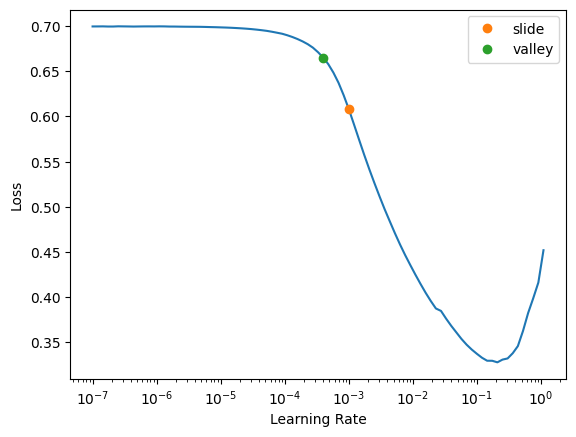

In [36]:
learner.lr_find(suggest_funcs=[slide, valley])

In [38]:
learner.fit_one_cycle(2,0.0006995531057855934)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.020756,0.019660,0.995291,01:11
1,0.019038,0.018835,0.995785,01:11


In [39]:
learner.save("Quote-classifier-stage-with29k-data-0")

Path('models/Quote-classifier-stage-with29k-data-0.pth')

In [40]:
learner.export("models/Quote-classifier-stage-with29k-data-0.pkl")

In [41]:
learner.unfreeze()

SuggestedLRs(slide=9.120108734350652e-05, valley=7.585775892948732e-05)

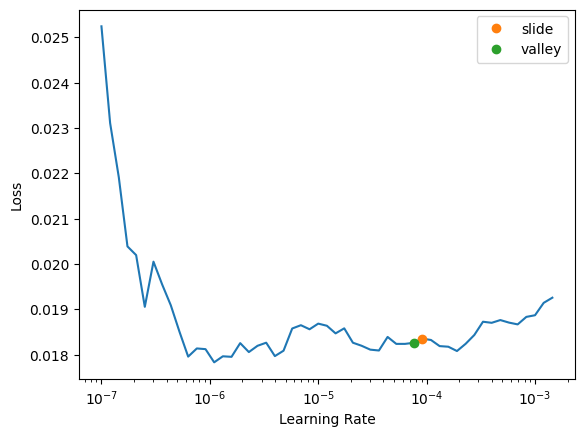

In [42]:
learner.lr_find(suggest_funcs=[slide, valley])

In [43]:
learner.fit_one_cycle(5,slice(7.585775892948732e-05,9.120108734350652e-05))

epoch,train_loss,valid_loss,accuracy_multi,time


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.018319,0.018121,0.995523,01:46
1,0.016918,0.017107,0.996009,01:48
2,0.016566,0.016436,0.996039,01:48
3,0.014810,0.015847,0.996191,01:48
4,0.014863,0.015758,0.996149,01:48


In [44]:
learner.save("Quote-classifier-stage-with29k-data-1")

Path('models/Quote-classifier-stage-with29k-data-1.pth')

In [45]:
learner.export("models/Quote-classifier-stage-with29k-data-1.pkl")